딥러닝응용 5주차 과제
==
Implement PCA on diabetes dataset

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim


## Load Data

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.shape

(768, 9)

## Data Preprocessing
1. Extract target ['Outcome']
2. Train/Test/Val split
3. Scale using StandardScaler
4. Perform PCA

In [5]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Plot Data (Scaling)

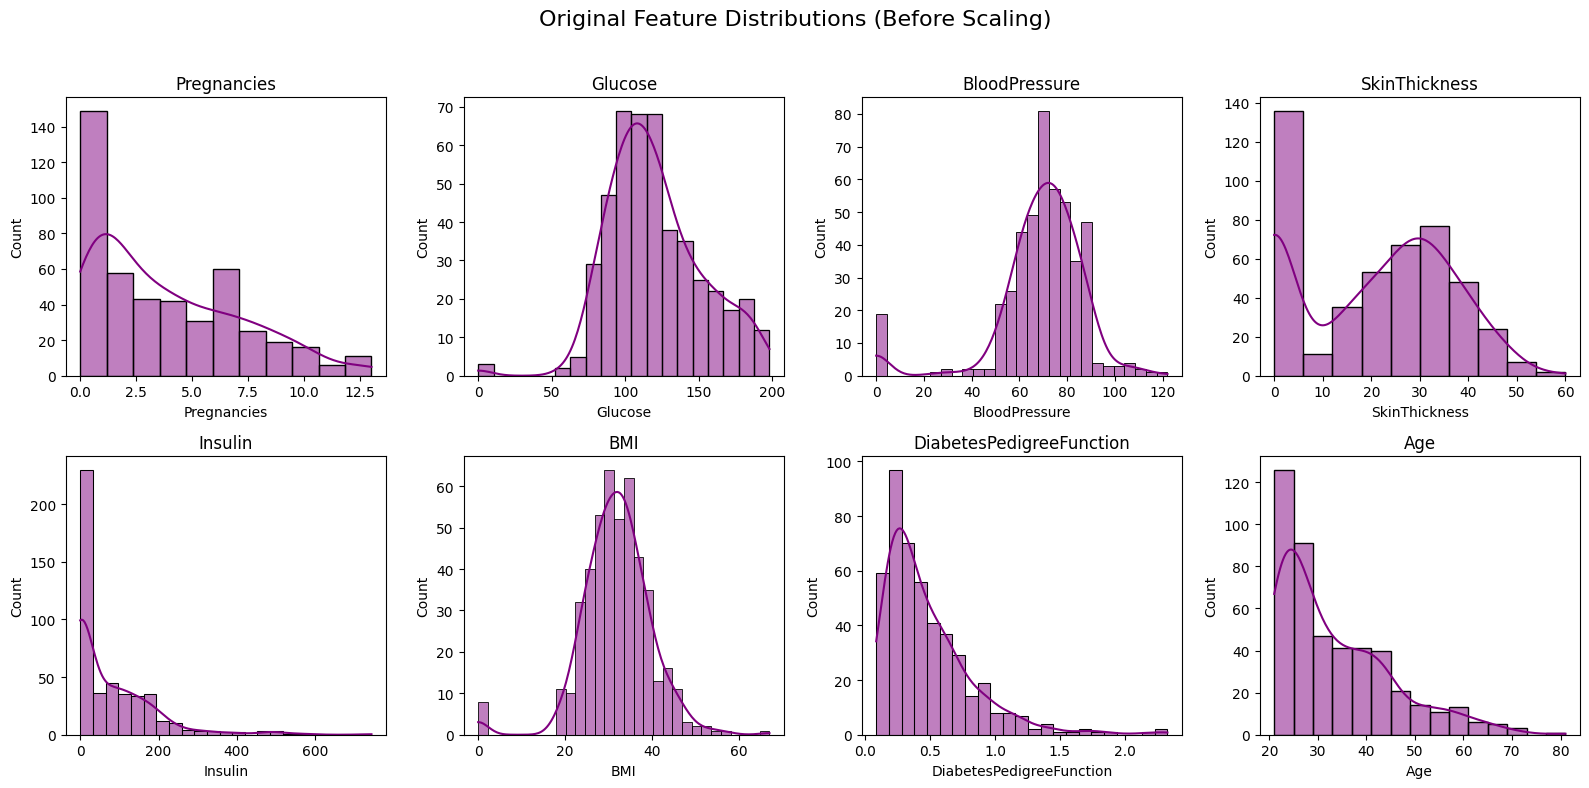

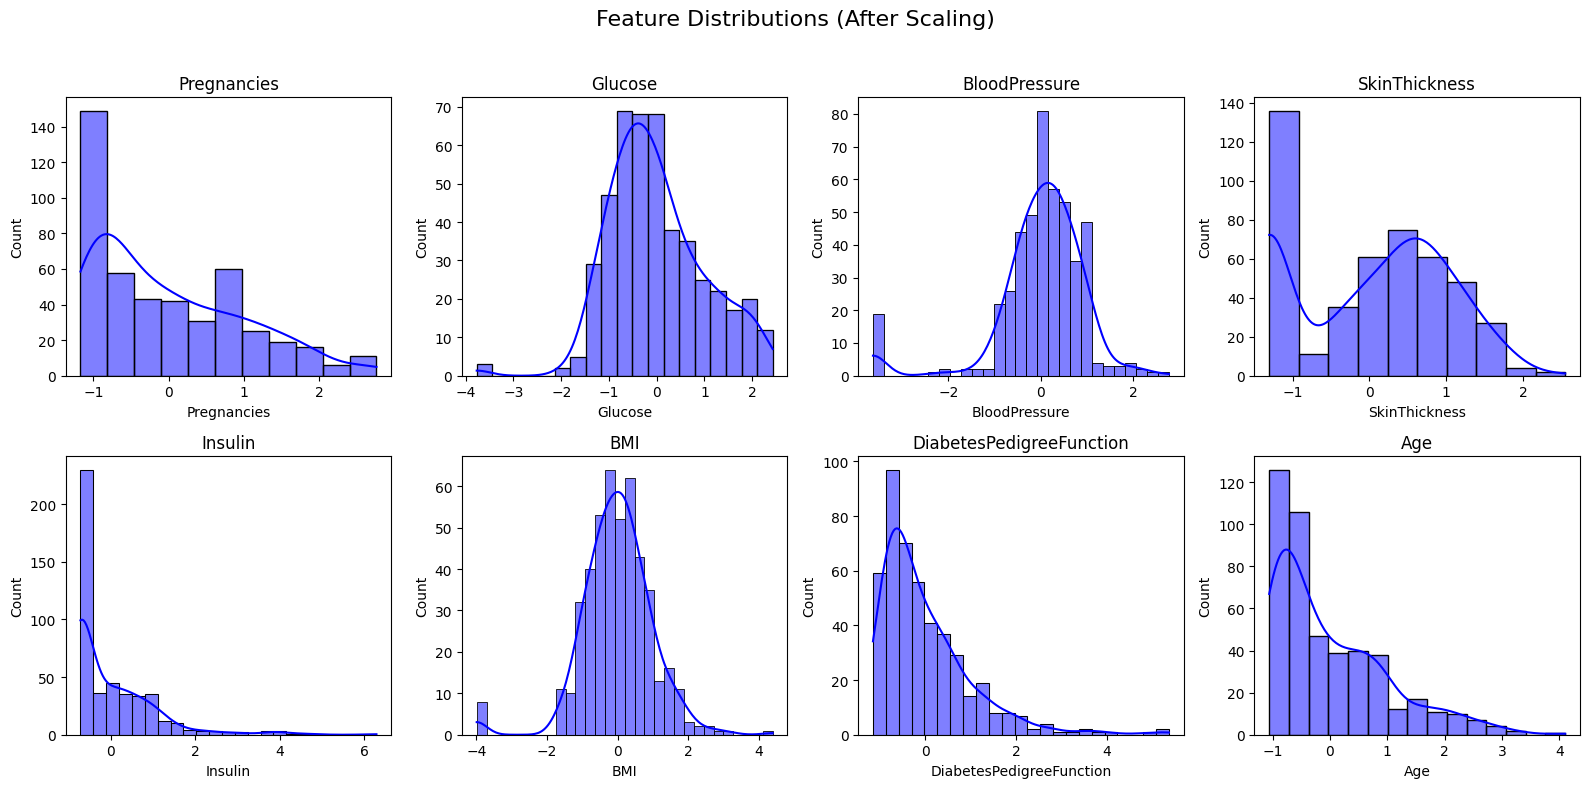

In [6]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Plotting the original features (before scaling)
plt.figure(figsize=(16, 8))
plt.suptitle("Original Feature Distributions (Before Scaling)", fontsize=16)
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(X_train_df[column], kde=True, color='purple')
    plt.title(column)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plotting the scaled features (after scaling)
plt.figure(figsize=(16, 8))
plt.suptitle("Feature Distributions (After Scaling)", fontsize=16)
for i, column in enumerate(X_train_scaled_df.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(X_train_scaled_df[column], kde=True, color='blue')
    plt.title(column)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Plot Data (Correlation Matrix)

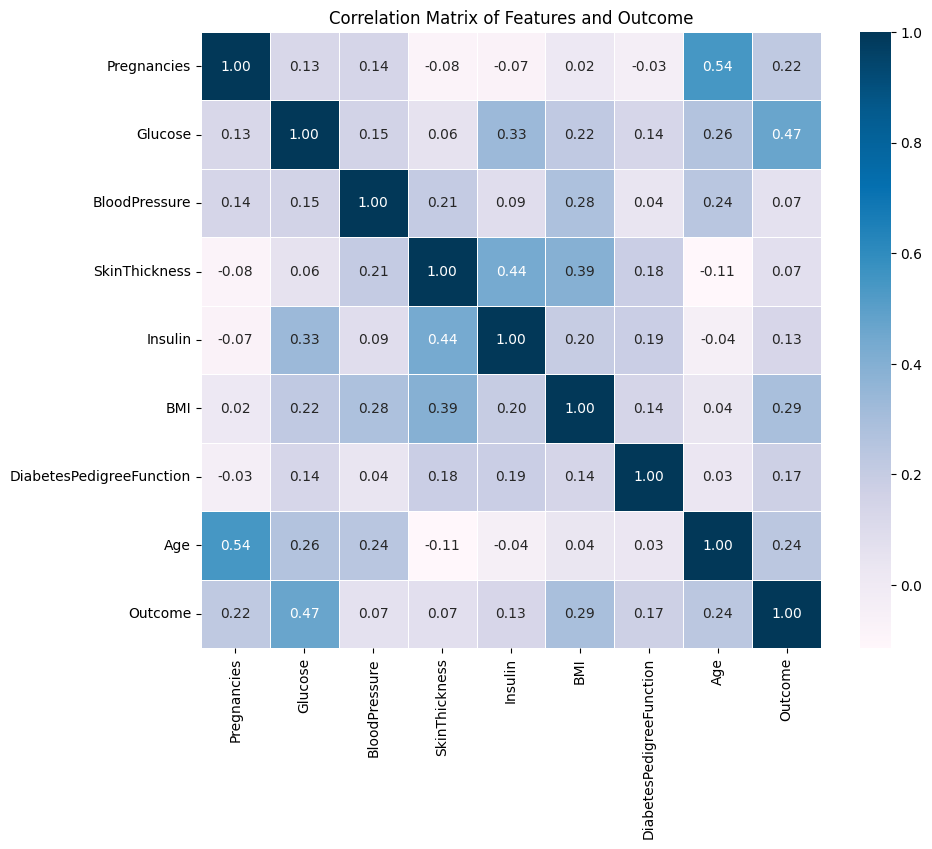

In [7]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PuBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features and Outcome')
plt.show()

### Apply PCA

In [8]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

### Plot PCA Results

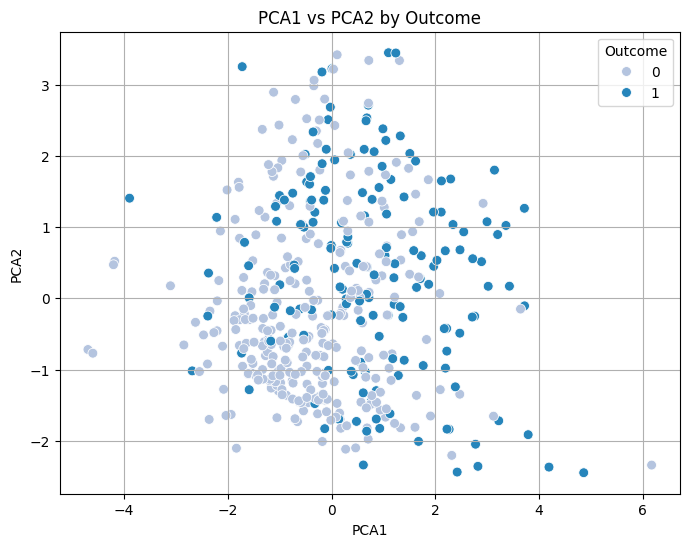

In [9]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_scaled_df['Outcome'] = y_train.values

X_train_scaled_df['PCA1'] = X_train_pca[:, 0]
X_train_scaled_df['PCA2'] = X_train_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Outcome', palette='PuBu', data=X_train_scaled_df, s=50)

plt.title('PCA1 vs PCA2 by Outcome')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [10]:
# Choose depending on explained_variance_ratio_
# pca = PCA()
# pca.fit(X_train)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

# pca = PCA(n_components=0.95)
# X_reduced = pca.fit_transform(X_train)
# pca.n_components_

## RandomForest
1. Classification using full features
2. Classification using pca features

Original Features:
Accuracy: 0.7403
Time taken: 0.9918 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       101
           1       0.63      0.58      0.61        53

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.74      0.74      0.74       154


PCA Features:
Accuracy: 0.7078
Time taken: 0.8640 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       101
           1       0.60      0.47      0.53        53

    accuracy                           0.71       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.70      0.71      0.70       154



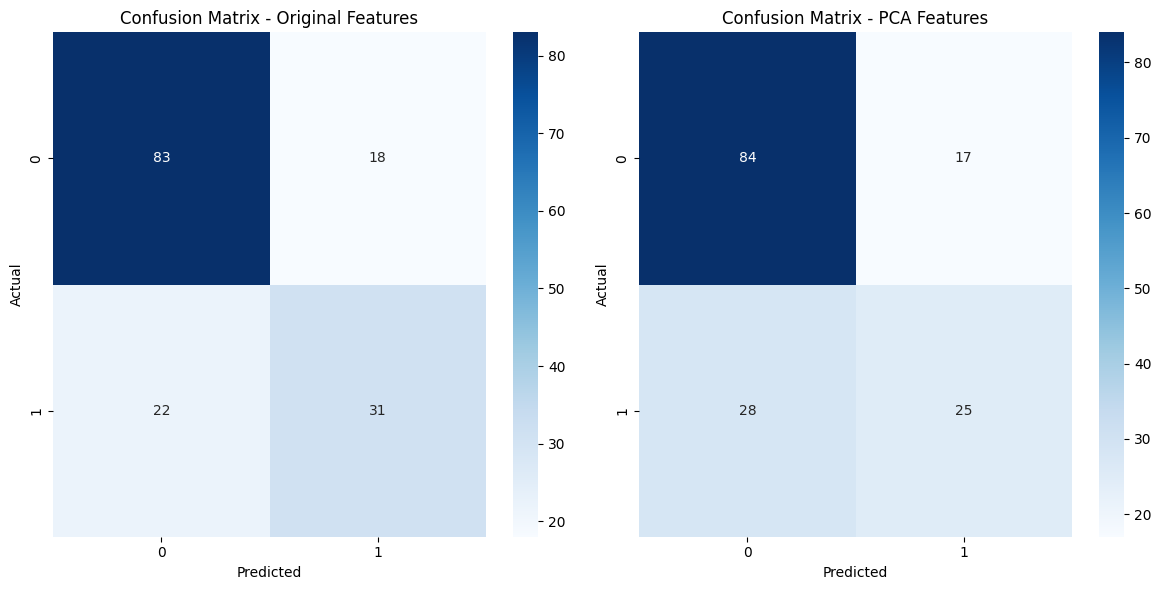

In [11]:
# 1. Random Forest with Original Features
start_time = time.time()
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train_scaled, y_train)

# Predictions
y_val_pred_original = rf_original.predict(X_val_scaled)

# Performance Metrics
rf_accuracy_original = accuracy_score(y_val, y_val_pred_original)
conf_matrix_original = confusion_matrix(y_val, y_val_pred_original)
end_time = time.time()

# 2. PCA on Original Features
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Random Forest with PCA Features
start_time_pca = time.time()
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)

# Predictions
y_val_pred_pca = rf_pca.predict(X_val_pca)

# Performance Metrics
rf_accuracy_pca = accuracy_score(y_val, y_val_pred_pca)
conf_matrix_pca = confusion_matrix(y_val, y_val_pred_pca)
end_time_pca = time.time()

# Print Results
print(f"Original Features:\nAccuracy: {rf_accuracy_original:.4f}")
print(f"Time taken: {end_time - start_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_original))

print(f"\nPCA Features:\nAccuracy: {rf_accuracy_pca:.4f}")
print(f"Time taken: {end_time_pca - start_time_pca:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_pca))

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_original, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Original Features')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_pca, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - PCA Features')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## SVM Classifier
1. Classification using full features
2. Classification using pca features

Original Features:
Accuracy: 0.7273
Time taken: 0.0227 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       101
           1       0.63      0.51      0.56        53

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.72      0.73      0.72       154


PCA Features:
Accuracy: 0.7143
Time taken: 0.0345 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       101
           1       0.62      0.43      0.51        53

    accuracy                           0.71       154
   macro avg       0.68      0.65      0.65       154
weighted avg       0.70      0.71      0.70       154



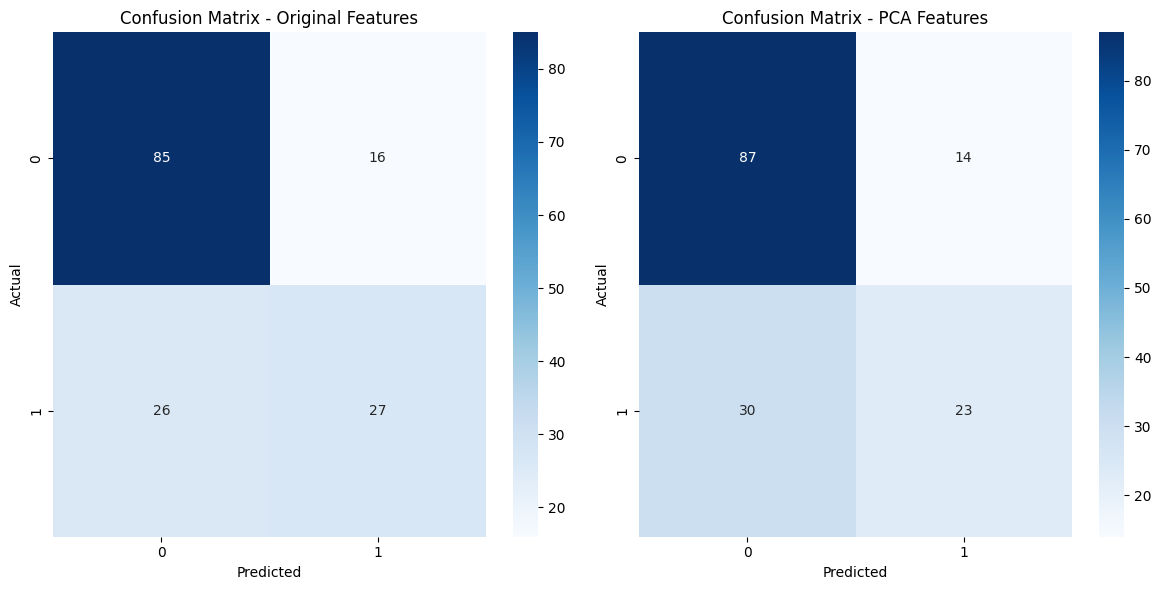

In [12]:
# 1. SVM with Original Features
start_time = time.time()
svm_original = SVC(random_state=42)
svm_original.fit(X_train_scaled, y_train)

# Predictions
y_val_pred_original = svm_original.predict(X_val_scaled)

# Performance Metrics
svm_accuracy_original = accuracy_score(y_val, y_val_pred_original)
conf_matrix_original = confusion_matrix(y_val, y_val_pred_original)
end_time = time.time()

# 2. PCA on Original Features
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# SVM with PCA Features
start_time_pca = time.time()
svm_pca = SVC(random_state=42)
svm_pca.fit(X_train_pca, y_train)

# Predictions
y_val_pred_pca = svm_pca.predict(X_val_pca)

# Performance Metrics
svm_accuracy_pca = accuracy_score(y_val, y_val_pred_pca)
conf_matrix_pca = confusion_matrix(y_val, y_val_pred_pca)
end_time_pca = time.time()

# Print Results
print(f"Original Features:\nAccuracy: {svm_accuracy_original:.4f}")
print(f"Time taken: {end_time - start_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_original))

print(f"\nPCA Features:\nAccuracy: {svm_accuracy_pca:.4f}")
print(f"Time taken: {end_time_pca - start_time_pca:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_pca))

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_original, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Original Features')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_pca, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - PCA Features')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## CNN

### Create Sequences
window_size=3

In [13]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [14]:
# Hyperparameters
n_steps = 3
num_epochs = 20
learning_rate = 0.001
batch_size = 32

## Create Dataset

### 1. Original Features

In [15]:
# Combine features and target into a single DataFrame
sequences = pd.concat([X, y], axis=1)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sequences.iloc[:, :-1])  # Scale only the features
sequences_scaled = pd.DataFrame(X_scaled, columns=sequences.columns[:-1])
sequences_scaled[sequences.columns[-1]] = sequences.iloc[:, -1].values  # Add the target back

# Create sequences
X_sequences, y_sequences = split_sequences(sequences_scaled.values, n_steps)

# Prepare tensors
X_sequences_tensor = torch.FloatTensor(X_sequences)
y_sequences_tensor = torch.LongTensor(y_sequences)

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X_sequences_tensor, y_sequences_tensor, test_size=0.4, random_state=42, stratify=y_sequences)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create DataLoaders for original features
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print shapes of features
print(f"Shape of features (X_sequences_tensor): {X_sequences_tensor.shape}")
print(f"Shape of labels (y_sequences_tensor): {y_sequences_tensor.shape}")

# Check sizes of train, validation, and test sets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Check distributions of target classes in each set
train_class_distribution = torch.bincount(y_train)
val_class_distribution = torch.bincount(y_val)
test_class_distribution = torch.bincount(y_test)

print(f"Training set class distribution: {train_class_distribution}")
print(f"Validation set class distribution: {val_class_distribution}")
print(f"Test set class distribution: {test_class_distribution}")

Shape of features (X_sequences_tensor): torch.Size([766, 3, 8])
Shape of labels (y_sequences_tensor): torch.Size([766])
Training set size: 459
Validation set size: 154
Test set size: 153
Training set class distribution: tensor([333, 126])
Validation set class distribution: tensor([111,  43])
Test set class distribution: tensor([111,  42])


In [16]:
# PCA Transformation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Prepare tensors for PCA features
X_pca_sequences = np.array([X_pca[i:i + n_steps] for i in range(len(X_pca) - n_steps + 1)])
y_pca_sequences = np.array([Counter(y[i:i + n_steps]).most_common(1)[0][0] for i in range(len(y) - n_steps + 1)])

# Prepare tensors
X_pca_sequences_tensor = torch.FloatTensor(X_pca_sequences)
y_pca_sequences_tensor = torch.LongTensor(y_pca_sequences)

# Split Data
X_train_pca, X_temp_pca, y_train_pca, y_temp_pca = train_test_split(X_pca_sequences_tensor, y_pca_sequences_tensor, test_size=0.4, random_state=42, stratify=y_pca_sequences)
X_test_pca, X_val_pca, y_test_pca, y_val_pca = train_test_split(X_temp_pca, y_temp_pca, test_size=0.5, random_state=42, stratify=y_temp_pca)

# Create DataLoaders for PCA features
train_dataset_pca = TensorDataset(X_train_pca, y_train_pca)
val_dataset_pca = TensorDataset(X_val_pca, y_val_pca)
test_dataset_pca = TensorDataset(X_test_pca, y_test_pca)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=batch_size, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

# Print shapes of PCA features
print(f"Shape of PCA features (X_pca_sequences_tensor): {X_pca_sequences_tensor.shape}")
print(f"Shape of PCA labels (y_pca_sequences_tensor): {y_pca_sequences_tensor.shape}")

# Check sizes of train, validation, and test sets for PCA features
print(f"PCA Training set size: {len(train_dataset_pca)}")
print(f"PCA Validation set size: {len(val_dataset_pca)}")
print(f"PCA Test set size: {len(test_dataset_pca)}")

# Check distributions of target classes in each PCA set
train_class_distribution_pca = torch.bincount(y_train_pca)
val_class_distribution_pca = torch.bincount(y_val_pca)
test_class_distribution_pca = torch.bincount(y_test_pca)

print(f"PCA Training set class distribution: {train_class_distribution_pca}")
print(f"PCA Validation set class distribution: {val_class_distribution_pca}")
print(f"PCA Test set class distribution: {test_class_distribution_pca}")

Shape of PCA features (X_pca_sequences_tensor): torch.Size([766, 3, 2])
Shape of PCA labels (y_pca_sequences_tensor): torch.Size([766])
PCA Training set size: 459
PCA Validation set size: 154
PCA Test set size: 153
PCA Training set class distribution: tensor([333, 126])
PCA Validation set class distribution: tensor([111,  43])
PCA Test set class distribution: tensor([111,  42])


### CNN Model

In [17]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, n_steps, in_channels):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=2)  # 1 Conv Layer
        self.pool = nn.MaxPool1d(kernel_size=1)  # Keep pool size to 1 to maintain size
        self.flattened_size = 16 * (n_steps - 2 + 1)  # Output size after Conv1D and Pooling

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Train Loop

In [18]:
# Function to train and evaluate the model
def train_and_evaluate_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, num_classes, n_steps, in_channels):
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = CNNModel(num_classes, n_steps, in_channels)
    criterion = nn.BCEWithLogitsLoss()  # Binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training the model
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            optimizer.zero_grad()  # Zero the gradients

            inputs = inputs.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length)
            outputs = model(inputs)

            labels = labels.float().view(-1, 1)  # Reshape labels for BCE loss
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predicted = torch.round(torch.sigmoid(outputs))  # Get predicted labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Store average training loss and accuracy
        avg_loss = running_loss / len(train_loader)
        avg_accuracy = correct_train / total_train
        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)

        # Validation
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        y_val_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.permute(0, 2, 1))
                loss = criterion(outputs, labels.float().view(-1, 1))  # Calculate validation loss
                running_val_loss += loss.item()

                predicted = torch.round(torch.sigmoid(outputs))
                y_val_pred.extend(predicted.numpy())
                total_val += labels.size(0)
                correct_val += (predicted == labels.view(-1, 1)).sum().item()

        # Store average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

    end_time = time.time()
    print(f"Training completed in: {end_time - start_time:.2f} seconds")

    # Evaluate on Test Set
    y_test_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.permute(0, 2, 1))
            predicted = torch.round(torch.sigmoid(outputs))
            y_test_pred.extend(predicted.numpy())

    # Performance Metrics on Test Set
    accuracy_test = np.mean(np.array(y_test_pred) == y_test_tensor.numpy().reshape(-1, 1))
    print(f"Test Accuracy: {accuracy_test:.4f}")

    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 10))

    # Plot Training Loss vs Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Training Accuracy vs Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test_tensor.numpy(), np.array(y_test_pred).reshape(-1, 1))
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy_test

## Evaluation

### 1. Original features evaluation

Evaluating model on original features...


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 331.64batch/s]


Loss: 0.6795, Validation Loss: 0.6556, Train Accuracy: 0.5359, Validation Accuracy: 0.7078


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 364.43batch/s]


Loss: 0.6266, Validation Loss: 0.6142, Train Accuracy: 0.7255, Validation Accuracy: 0.7208


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 395.31batch/s]


Loss: 0.5944, Validation Loss: 0.5815, Train Accuracy: 0.7255, Validation Accuracy: 0.7208


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 375.88batch/s]


Loss: 0.5577, Validation Loss: 0.5562, Train Accuracy: 0.7255, Validation Accuracy: 0.7208


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 345.52batch/s]


Loss: 0.5332, Validation Loss: 0.5347, Train Accuracy: 0.7255, Validation Accuracy: 0.7338


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 365.57batch/s]


Loss: 0.5225, Validation Loss: 0.5183, Train Accuracy: 0.7342, Validation Accuracy: 0.7338


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 348.23batch/s]


Loss: 0.4936, Validation Loss: 0.5047, Train Accuracy: 0.7429, Validation Accuracy: 0.7273


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 330.95batch/s]


Loss: 0.4778, Validation Loss: 0.4952, Train Accuracy: 0.7538, Validation Accuracy: 0.7338


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 346.67batch/s]


Loss: 0.4584, Validation Loss: 0.4881, Train Accuracy: 0.7625, Validation Accuracy: 0.7403


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 227.02batch/s]


Loss: 0.4535, Validation Loss: 0.4821, Train Accuracy: 0.7560, Validation Accuracy: 0.7532


Epoch 11/20: 100%|██████████| 15/15 [00:00<00:00, 277.13batch/s]


Loss: 0.4425, Validation Loss: 0.4804, Train Accuracy: 0.7625, Validation Accuracy: 0.7532


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 255.53batch/s]


Loss: 0.4283, Validation Loss: 0.4785, Train Accuracy: 0.7800, Validation Accuracy: 0.7468


Epoch 13/20: 100%|██████████| 15/15 [00:00<00:00, 297.19batch/s]


Loss: 0.4147, Validation Loss: 0.4797, Train Accuracy: 0.7887, Validation Accuracy: 0.7468


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 274.46batch/s]


Loss: 0.4071, Validation Loss: 0.4813, Train Accuracy: 0.7952, Validation Accuracy: 0.7468


Epoch 15/20: 100%|██████████| 15/15 [00:00<00:00, 342.20batch/s]


Loss: 0.4212, Validation Loss: 0.4820, Train Accuracy: 0.7930, Validation Accuracy: 0.7468


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 356.30batch/s]


Loss: 0.3932, Validation Loss: 0.4838, Train Accuracy: 0.7996, Validation Accuracy: 0.7468


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 340.52batch/s]


Loss: 0.3938, Validation Loss: 0.4859, Train Accuracy: 0.8083, Validation Accuracy: 0.7468


Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 339.87batch/s]


Loss: 0.3836, Validation Loss: 0.4819, Train Accuracy: 0.8148, Validation Accuracy: 0.7338


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 350.09batch/s]


Loss: 0.3765, Validation Loss: 0.4828, Train Accuracy: 0.8170, Validation Accuracy: 0.7338


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 343.48batch/s]


Loss: 0.3819, Validation Loss: 0.4850, Train Accuracy: 0.8192, Validation Accuracy: 0.7403
Training completed in: 1.30 seconds
Test Accuracy: 0.7451


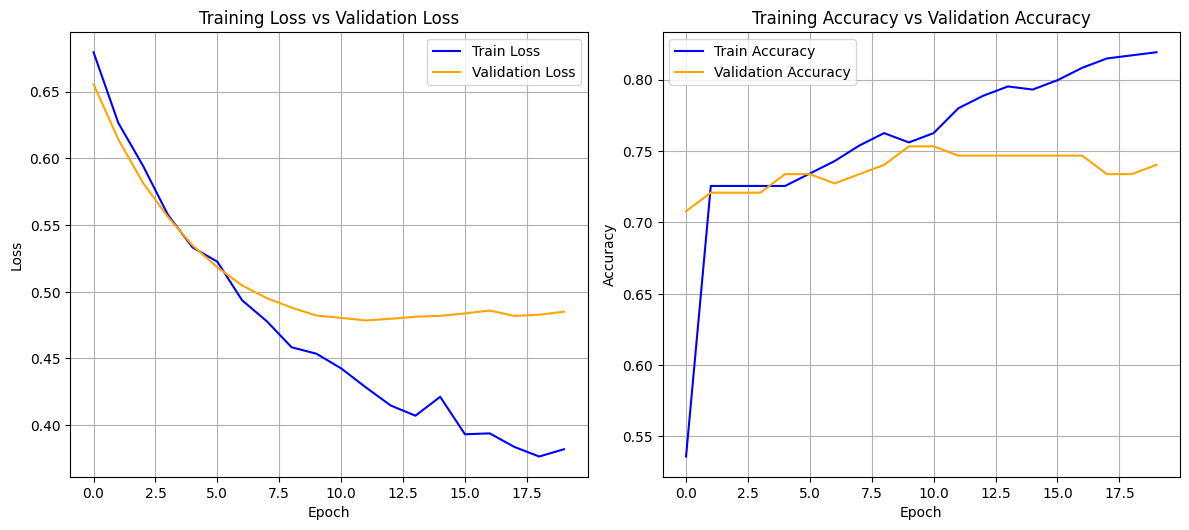

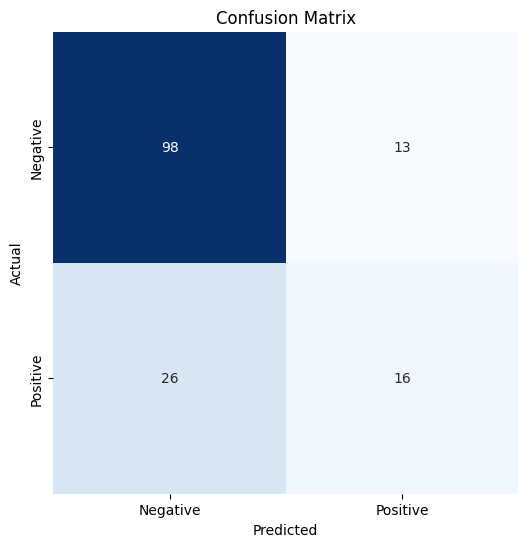

In [25]:
print("Evaluating model on original features...")
cnn_accuracy_original = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, 1, n_steps, X_train.shape[2])  # 1 for binary classification


### 2. PCA features evaluation

Evaluating model on PCA features...


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 121.41batch/s]


Loss: 0.7438, Validation Loss: 0.6813, Train Accuracy: 0.3355, Validation Accuracy: 0.5779


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 141.53batch/s]


Loss: 0.6416, Validation Loss: 0.6192, Train Accuracy: 0.7081, Validation Accuracy: 0.7208


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 207.78batch/s]


Loss: 0.5972, Validation Loss: 0.5796, Train Accuracy: 0.7255, Validation Accuracy: 0.7208


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 59.14batch/s]


Loss: 0.5639, Validation Loss: 0.5504, Train Accuracy: 0.7255, Validation Accuracy: 0.7208


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 78.28batch/s]


Loss: 0.5296, Validation Loss: 0.5287, Train Accuracy: 0.7277, Validation Accuracy: 0.7273


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 57.64batch/s]


Loss: 0.5139, Validation Loss: 0.5149, Train Accuracy: 0.7407, Validation Accuracy: 0.7338


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 97.52batch/s] 


Loss: 0.4975, Validation Loss: 0.5071, Train Accuracy: 0.7560, Validation Accuracy: 0.7403


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 83.10batch/s]


Loss: 0.4959, Validation Loss: 0.5029, Train Accuracy: 0.7560, Validation Accuracy: 0.7468


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 100.35batch/s]


Loss: 0.5061, Validation Loss: 0.5010, Train Accuracy: 0.7625, Validation Accuracy: 0.7338


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 48.65batch/s]


Loss: 0.4944, Validation Loss: 0.5009, Train Accuracy: 0.7603, Validation Accuracy: 0.7403


Epoch 11/20: 100%|██████████| 15/15 [00:00<00:00, 94.22batch/s] 


Loss: 0.4820, Validation Loss: 0.5001, Train Accuracy: 0.7647, Validation Accuracy: 0.7532


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 37.57batch/s]


Loss: 0.4837, Validation Loss: 0.4974, Train Accuracy: 0.7625, Validation Accuracy: 0.7403


Epoch 13/20: 100%|██████████| 15/15 [00:00<00:00, 56.20batch/s]


Loss: 0.4860, Validation Loss: 0.4974, Train Accuracy: 0.7691, Validation Accuracy: 0.7338


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 111.15batch/s]


Loss: 0.4884, Validation Loss: 0.4969, Train Accuracy: 0.7691, Validation Accuracy: 0.7468


Epoch 15/20: 100%|██████████| 15/15 [00:00<00:00, 114.65batch/s]


Loss: 0.4845, Validation Loss: 0.4965, Train Accuracy: 0.7582, Validation Accuracy: 0.7468


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 71.96batch/s]


Loss: 0.4786, Validation Loss: 0.4954, Train Accuracy: 0.7625, Validation Accuracy: 0.7403


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 87.32batch/s]

Loss: 0.4684, Validation Loss: 0.4956, Train Accuracy: 0.7669, Validation Accuracy: 0.7403

Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 107.79batch/s]


Loss: 0.4883, Validation Loss: 0.4952, Train Accuracy: 0.7669, Validation Accuracy: 0.7468


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 105.33batch/s]


Loss: 0.4692, Validation Loss: 0.4956, Train Accuracy: 0.7669, Validation Accuracy: 0.7403


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 109.84batch/s]


Loss: 0.4715, Validation Loss: 0.4945, Train Accuracy: 0.7691, Validation Accuracy: 0.7468
Training completed in: 4.53 seconds
Test Accuracy: 0.7255


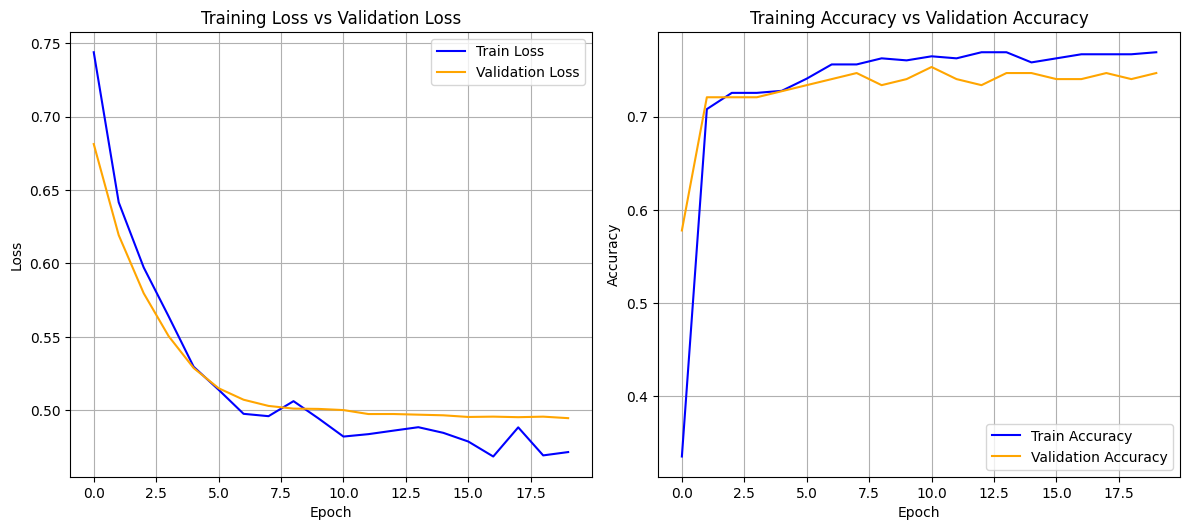

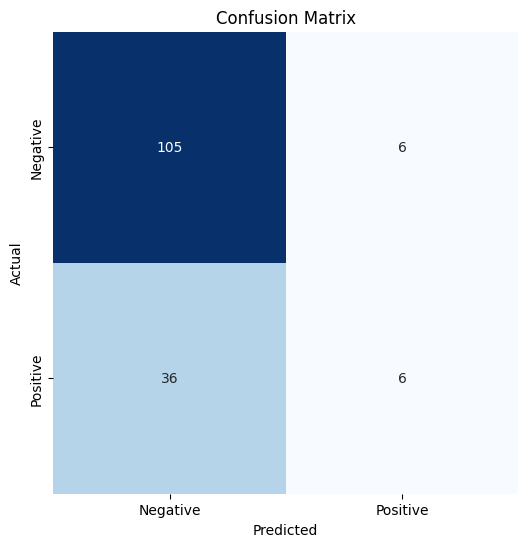

In [28]:
print("Evaluating model on PCA features...")
cnn_accuracy_pca = train_and_evaluate_model(X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca, 1, n_steps, X_train_pca.shape[2])  # 1 for binary classification

## Finalization

### Observation
Decreasing the features using PCA (8 to 2) did not increase the performance of the model, but yields similar results while lowering time and computational units.

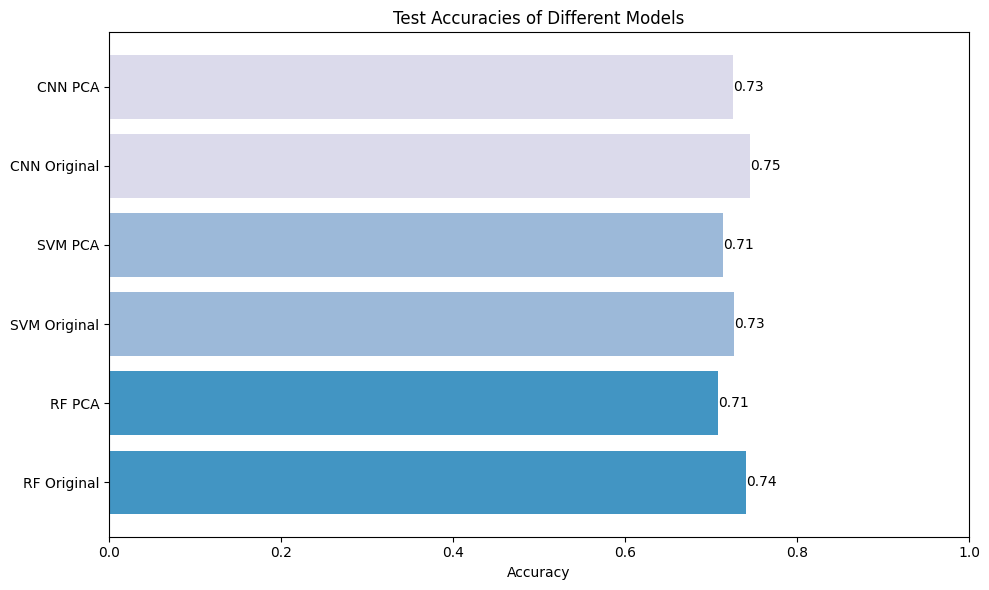

In [29]:
# Define accuracies
accuracies = [
    rf_accuracy_original,
    rf_accuracy_pca,
    svm_accuracy_original,
    svm_accuracy_pca,
    cnn_accuracy_original,
    cnn_accuracy_pca
]

# Define labels for the bars
labels = [
    'RF Original',
    'RF PCA',
    'SVM Original',
    'SVM PCA',
    'CNN Original',
    'CNN PCA'
]

# Define colors for each model
colors = [
    plt.get_cmap('PuBu')(0.6),  # RF Original
    plt.get_cmap('PuBu')(0.6),  # RF PCA
    plt.get_cmap('PuBu')(0.4),  # SVM Original
    plt.get_cmap('PuBu')(0.4),  # SVM PCA
    plt.get_cmap('PuBu')(0.2),  # CNN Original
    plt.get_cmap('PuBu')(0.2)   # CNN PCA
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Test Accuracies of Different Models')
plt.xlim(0, 1)
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'{xval:.2f}', va='center')
plt.tight_layout()
plt.show()